In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import ImageFile
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/covid_detection/dataset/train6'
valid_data_dir = '/content/drive/My Drive/Colab Notebooks/covid_detection/dataset/validation6'
test_data_dir = '/content/drive/My Drive/Colab Notebooks/covid_detection/dataset/test6'

In [ ]:
# num_class = 2
# image_dim = 224
batch_size = 8

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.RandomRotation(10),                                          
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=0.485,
                                                                std=0.229)])

valid_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485 ,std= 0.229)])

test_data_transform = transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485,
                                                                std= 0.229)])

train_data = datasets.ImageFolder(train_data_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_data_dir, transform=valid_data_transform)
test_data = datasets.ImageFolder(test_data_dir, transform=test_data_transform)
train_data_load = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_data_load = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_data_load = DataLoader(test_data,batch_size=batch_size, shuffle = True)

In [ ]:
use_cuda = torch.cuda.is_available()

In [ ]:
len(valid_data_load)

25

In [ ]:
loaders_transfer = {'train': train_data_load, 'valid': valid_data_load, 'test': test_data_load}

In [ ]:
model_transfer = models.resnet152(pretrained=True)
model_transfer.out = nn.Linear(2048, 2)

if use_cuda:
    model_transfer = model_transfer.cuda() 

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.001)

In [ ]:
tl,vl,ta=[],[],[]
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        correct=0
        total=0

        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            out = model(data)
            
            loss = criterion(out, target)
            
            loss.backward()
            optimizer.step()
            train_loss += ((1/(batch_idx + 1)) * (loss.data - train_loss))
            
            _, predicted = out.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            out = model(data)
            
            loss = criterion(out, target)
            valid_loss += ((1/(batch_idx + 1)) * (loss.data - valid_loss))
            
        ta.append(100. * correct/total) 
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        tl.append(train_loss)
        vl.append(valid_loss)
        
        #save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Valid loss decrease to  ({:.5f} -> {:.5f}). Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
   
    # return trained model
    return model

In [ ]:
n_epochs = 45
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.18593 	Validation Loss: 3.40293
Valid loss decrease to  (inf -> 3.40293). Saving model ...
Epoch: 2 	Training Loss: 0.51383 	Validation Loss: 0.99381
Valid loss decrease to  (3.40293 -> 0.99381). Saving model ...
Epoch: 3 	Training Loss: 0.53944 	Validation Loss: 0.56291
Valid loss decrease to  (0.99381 -> 0.56291). Saving model ...
Epoch: 4 	Training Loss: 0.40848 	Validation Loss: 0.58505
Epoch: 5 	Training Loss: 0.39053 	Validation Loss: 0.37538
Valid loss decrease to  (0.56291 -> 0.37538). Saving model ...
Epoch: 6 	Training Loss: 0.40291 	Validation Loss: 0.42569
Epoch: 7 	Training Loss: 0.32353 	Validation Loss: 0.57029
Epoch: 8 	Training Loss: 0.40417 	Validation Loss: 0.63458
Epoch: 9 	Training Loss: 0.46909 	Validation Loss: 0.69301
Epoch: 10 	Training Loss: 0.36363 	Validation Loss: 0.37088
Valid loss decrease to  (0.37538 -> 0.37088). Saving model ...
Epoch: 11 	Training Loss: 0.35495 	Validation Loss: 0.40144
Epoch: 12 	Training Loss: 0.24944 	Val

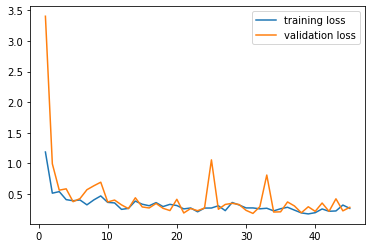

In [ ]:
tl1=[]
vl1=[]
a=[]
for i in tl:
    tl1.append(float(i))
for i in vl:
    vl1.append(float(i))
for i in range(1,46):
    a.append(i)
plt.plot(a,tl1,label='training loss')
plt.plot(a,vl1,label='validation loss')
plt.legend()

89.33333333333333

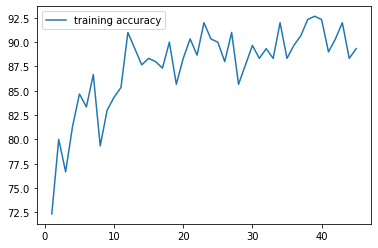

In [ ]:
ta1=[]
for i in ta:
    ta1.append(float(i))
plt.plot(a,ta1,label='training accuracy')
plt.legend()
ta1[-1]

In [ ]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [ ]:
testa,testl=[],[]
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target) 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
        print('Test Loss: {:.6f}\n'.format(test_loss))
        testl.append(float(test_loss))

        print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
            100. * correct / total, correct, total))
        testa.append(100. * correct / total)
        print('')

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.119670


Test Accuracy: 100% ( 8/ 8)

Test Loss: 0.108878


Test Accuracy: 100% (16/16)

Test Loss: 0.169748


Test Accuracy: 95% (23/24)

Test Loss: 0.190126


Test Accuracy: 93% (30/32)

Test Loss: 0.188266


Test Accuracy: 92% (37/40)

Test Loss: 0.181604


Test Accuracy: 93% (45/48)

Test Loss: 0.161310


Test Accuracy: 94% (53/56)

Test Loss: 0.159889


Test Accuracy: 93% (60/64)

Test Loss: 0.158424


Test Accuracy: 93% (67/72)

Test Loss: 0.157790


Test Accuracy: 93% (75/80)

Test Loss: 0.204174


Test Accuracy: 92% (81/88)

Test Loss: 0.190277


Test Accuracy: 92% (89/96)

Test Loss: 0.187053


Test Accuracy: 92% (96/104)

Test Loss: 0.210783


Test Accuracy: 91% (103/112)

Test Loss: 0.220058


Test Accuracy: 90% (109/120)

Test Loss: 0.219230


Test Accuracy: 90% (116/128)

Test Loss: 0.212208


Test Accuracy: 91% (124/136)

Test Loss: 0.210161


Test Accuracy: 90% (131/144)

Test Loss: 0.215037


Test Accuracy: 90% (138/152)

Test Loss: 0.209138


Test Accuracy

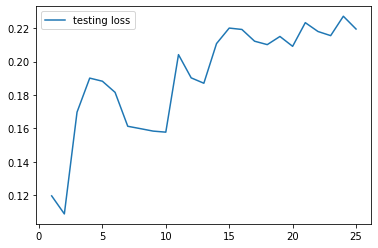

In [ ]:
testl1=[]
a=[]
for i in testl:
    testl1.append(float(i))
for i in range(len(testl1)):
    a.append(i+1)
plt.plot(a,testl1,label='testing loss')
plt.legend()

90.0


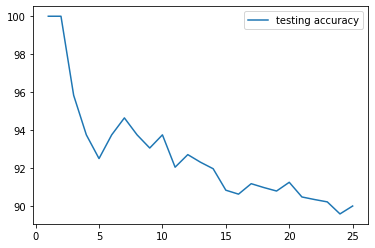

In [ ]:
testa1=[]
for i in testa:
    testa1.append(float(i))
print(testa1[-1])
plt.plot(a,testa1,label='testing accuracy')
plt.legend()